In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline


In [5]:
df = pd.read_csv("train_data.csv")
timestep = 1 #from 1 to 23 (17 with the current NaN strategy)
scaling = False #NOT WORKING YET
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
selected_features = ["risk", "time_to_tca","c_time_lastob_end",
            "c_time_lastob_start", "mahalanobis_distance",
            "max_risk_estimate", "max_risk_scaling",
            "miss_distance", "c_sigma_t", "relative_velocity_t",
            "event_length" , "c_actual_od_span", "c_recommended_od_span"    
           ]

In [6]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0))

df = df.groupby('event_id').filter(conditions)

#Getting y as 1D-array
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
if(scaling):
    _ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
    y = y_scaler.transform(y)

#Getting X as df (dropping rows with tca < 2) 
df = df.loc[df["time_to_tca"]>2]

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('count')

#Scaling X
if(scaling):
    df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Shifting features
features = list(df.columns)
X = pd.DataFrame()

for feature in features:
    for i in range(timestep-1,-1,-1):
        X[feature+'_t-'+str(i)] = df[feature].shift(i)
    
#Getting last row -> getting one row per event
X = X.groupby(["event_id_t-0"]).apply(lambda x: x.iloc[-1])
X = X.reset_index(drop=True)

#Deleting rows with more than one event_id
for i in range(timestep):
    X = X.loc[X["event_id_t-0"]==X["event_id_t-"+str(i)]]

#Dropping y values not included in X due to last condition
y = np.take(y, X.index)
y = y.reshape(-1, 1)

#Deleting event_id features
event_features = [feature for feature in list(X.columns) if feature.startswith('event_id_t-')]
X = X.drop(event_features, axis=1)

#adding targe feature to risk target
shifted_features = []
selected_features.append("mission_id")
selected_features.append("c_object_type")

for feature in selected_features:
    for shift in range(timestep):
        shifted_features.append(feature+"_t-"+str(shift))

X = X[shifted_features]
X["target_risk"] = y
df = X
df["mission_id_t-0"] = df["mission_id_t-0"].astype('category')
df["c_object_type_t-0"] = df["c_object_type_t-0"].astype('category')
df

C:\Users\karan\AppData\Local\Temp\ipykernel_10404\3980435455.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature+'_t-'+str(i)] = df[feature].shift(i)
C:\Users\karan\AppData\Local\Temp\ipykernel_10404\3980435455.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature+'_t-'+str(i)] = df[feature].shift(i)
C:\Users\karan\AppData\Local\Temp\ipykernel_10404\3980435455.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

,risk_t-0,time_to_tca_t-0,c_time_lastob_end_t-0,c_time_lastob_start_t-0,mahalanobis_distance_t-0,max_risk_estimate_t-0,max_risk_scaling_t-0,miss_distance_t-0,c_sigma_t_t-0,relative_velocity_t_t-0,event_length_t-0,c_actual_od_span_t-0,c_recommended_od_span_t-0,mission_id_t-0,c_object_type_t-0,target_risk
0,-30.000000,2.340627,2.0,180.0,227.820615,-6.266241,401.442549,18763.0,2922.327839,-13791.4,14,16.59,16.59,2,UNKNOWN,-30.000000
1,-30.000000,2.278941,2.0,180.0,287.224245,-7.320481,140.001151,23900.0,3764.712472,-12310.9,15,17.17,17.17,19,DEBRIS,-30.000000
2,-13.100070,2.103772,0.0,1.0,6.806426,-4.878440,23.068536,304.0,34.761214,-268.6,14,4.05,4.05,5,PAYLOAD,-30.000000
3,-30.000000,2.040187,0.0,1.0,194.076722,-5.079355,554.289715,10864.0,458.641254,-6638.6,15,12.07,12.07,1,DEBRIS,-30.000000
4,-18.845576,2.285275,0.0,1.0,95.434890,-6.102813,33.862812,4598.0,1003.595106,-10036.0,14,17.61,17.61,4,DEBRIS,-18.693361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7306,-8.498530,2.120492,2.0,180.0,237.124635,-6.113961,8.648661,18980.0,9442.438244,-11604.8,15,8.26,8.26,7,DEBRIS,-8.542724
7307,-30.000000,2.014028,0.0,1.0,31.716337,-5.223081,210.247272,3914.0,598.935138,-7008.2,16,6.36,6.36,7,PAYLOAD,-30.000000
7308,-30.000000,6.322295,0.0,1.0,130.975658,-7.004628,7361.969599,3569.0,18255.276712,-14862.5,2,3.53,3.53,9,DEBRIS,-30.000000
7309,-30.000000,2.128300,0.0,1.0,102.037990,-7.103143,1416.589071,24921.0,523.274880,-73.1,15,15.95,15.95,15,DEBRIS,-30.000000


C:\Users\karan\AppData\Local\Temp\ipykernel_10404\692792823.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.catplot(x=col, kind="count", data=df, palette="Set3")
C:\Users\karan\AppData\Local\Temp\ipykernel_10404\692792823.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xmajorticklabels(), rotation=90, fontsize = 13)
C:\Users\karan\AppData\Local\Temp\ipykernel_10404\692792823.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(axes[0].get_ymajorticklabels(), fontsize = 13)


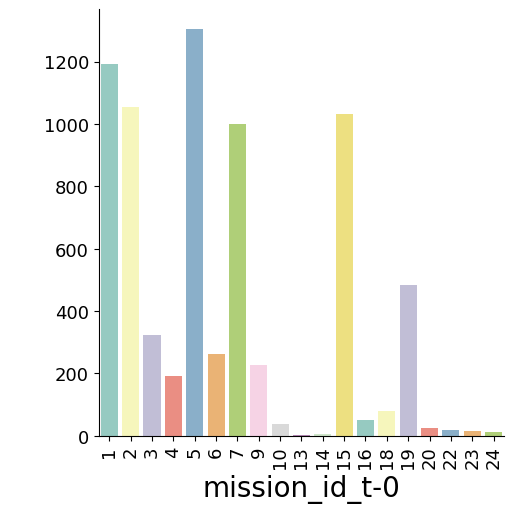

C:\Users\karan\AppData\Local\Temp\ipykernel_10404\692792823.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.catplot(x=col, kind="count", data=df, palette="Set3")
C:\Users\karan\AppData\Local\Temp\ipykernel_10404\692792823.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xmajorticklabels(), rotation=90, fontsize = 13)
C:\Users\karan\AppData\Local\Temp\ipykernel_10404\692792823.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(axes[0].get_ymajorticklabels(), fontsize = 13)


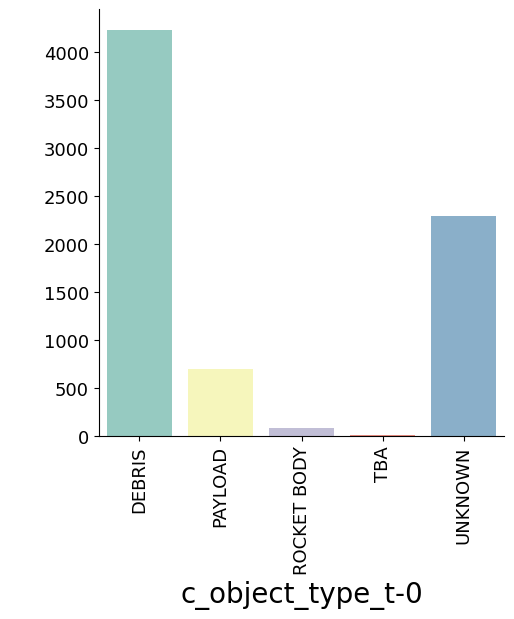

In [7]:
for col in df.select_dtypes(include='category').columns:
        fig = sns.catplot(x=col, kind="count", data=df, palette="Set3")
        axes = fig.axes.flatten()
        axes[0].set_xlabel(col,fontsize=20)
        axes[0].set_ylabel(" ",fontsize=20)
        axes[0].set_xticklabels(axes[0].get_xmajorticklabels(), rotation=90, fontsize = 13)
        axes[0].set_yticklabels(axes[0].get_ymajorticklabels(), fontsize = 13)        
        plt.show()

In [8]:
df.describe()

,risk_t-0,time_to_tca_t-0,c_time_lastob_end_t-0,c_time_lastob_start_t-0,mahalanobis_distance_t-0,max_risk_estimate_t-0,max_risk_scaling_t-0,miss_distance_t-0,c_sigma_t_t-0,relative_velocity_t_t-0,event_length_t-0,c_actual_od_span_t-0,c_recommended_od_span_t-0,target_risk
count,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7.311000e+03,7311.000000,7.311000e+03,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000
mean,-22.477264,2.240225,0.516892,33.328956,206.425280,-6.279670,2.446041e+04,16369.317604,1.234740e+06,-8802.643578,11.726576,12.117130,12.747740,-26.727299
std,9.400297,0.404080,0.780549,68.661076,330.239438,1.009847,3.683889e+05,14192.586796,8.685448e+06,5193.334219,4.415531,7.755397,9.688811,7.203487
min,-30.000000,2.000014,0.000000,1.000000,0.000008,-9.814175,3.277384e-11,40.000000,2.815477e+01,-16923.400000,1.000000,0.000000,0.000000,-30.000000
25%,-30.000000,2.088474,0.000000,1.000000,32.960991,-7.025350,1.623294e+01,4573.500000,9.107717e+02,-13965.200000,9.000000,6.560000,6.890000,-30.000000
50%,-30.000000,2.176575,0.000000,1.000000,104.823099,-6.328735,8.723831e+01,12250.000000,2.170204e+03,-9827.400000,14.000000,11.480000,11.680000,-30.000000
75%,-13.404780,2.269603,1.000000,2.000000,254.914402,-5.621330,4.109909e+02,25052.500000,6.738501e+03,-3803.150000,15.000000,16.330000,16.480000,-30.000000
max,-1.829152,6.941353,2.000000,180.000000,6091.557717,-1.470441,1.852132e+07,66175.000000,6.378136e+07,330.500000,17.000000,77.360000,181.080000,-3.501965


C:\Users\karan\AppData\Local\Temp\ipykernel_10404\882366906.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  hm = sns.boxplot(x=col, y="risk_t-0", data=df, palette="Set3")
C:\Users\karan\AppData\Local\Temp\ipykernel_10404\882366906.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  hm.set_xticklabels(hm.get_xmajorticklabels(), rotation=90, fontsize = 13)
C:\Users\karan\AppData\Local\Temp\ipykernel_10404\882366906.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18)


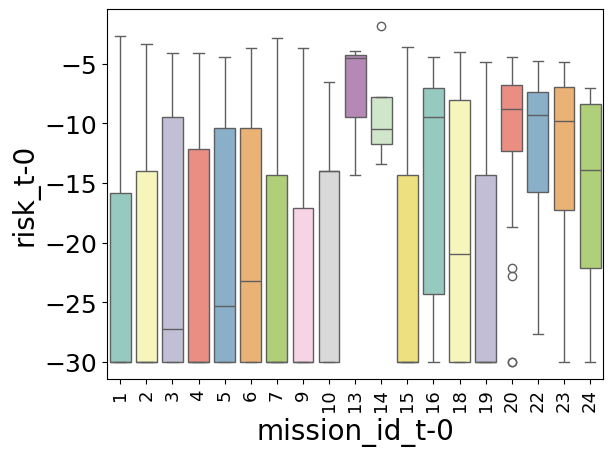

C:\Users\karan\AppData\Local\Temp\ipykernel_10404\882366906.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  hm = sns.boxplot(x=col, y="risk_t-0", data=df, palette="Set3")
C:\Users\karan\AppData\Local\Temp\ipykernel_10404\882366906.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  hm.set_xticklabels(hm.get_xmajorticklabels(), rotation=90, fontsize = 13)
C:\Users\karan\AppData\Local\Temp\ipykernel_10404\882366906.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18)


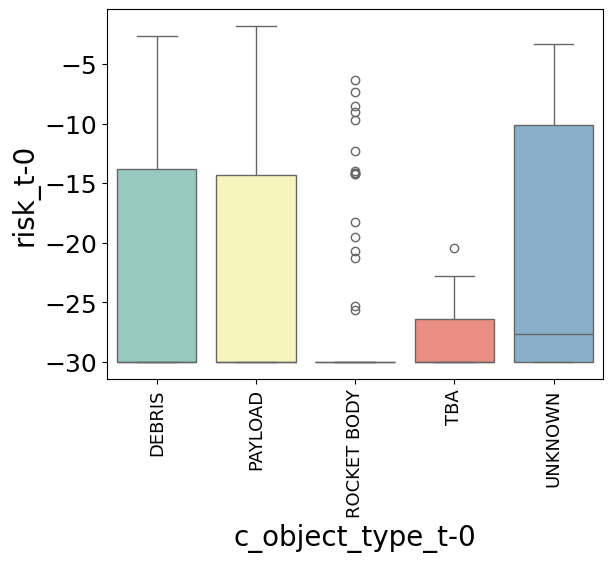

In [10]:
for col in df.select_dtypes(include='category').columns:
    hm = sns.boxplot(x=col, y="risk_t-0", data=df, palette="Set3")
    hm.set_xticklabels(hm.get_xmajorticklabels(), rotation=90, fontsize = 13)
    hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18)
    hm.set_xlabel(hm.get_xlabel(),fontsize=20)
    hm.set_ylabel(hm.get_ylabel(),fontsize=20)
    plt.show()

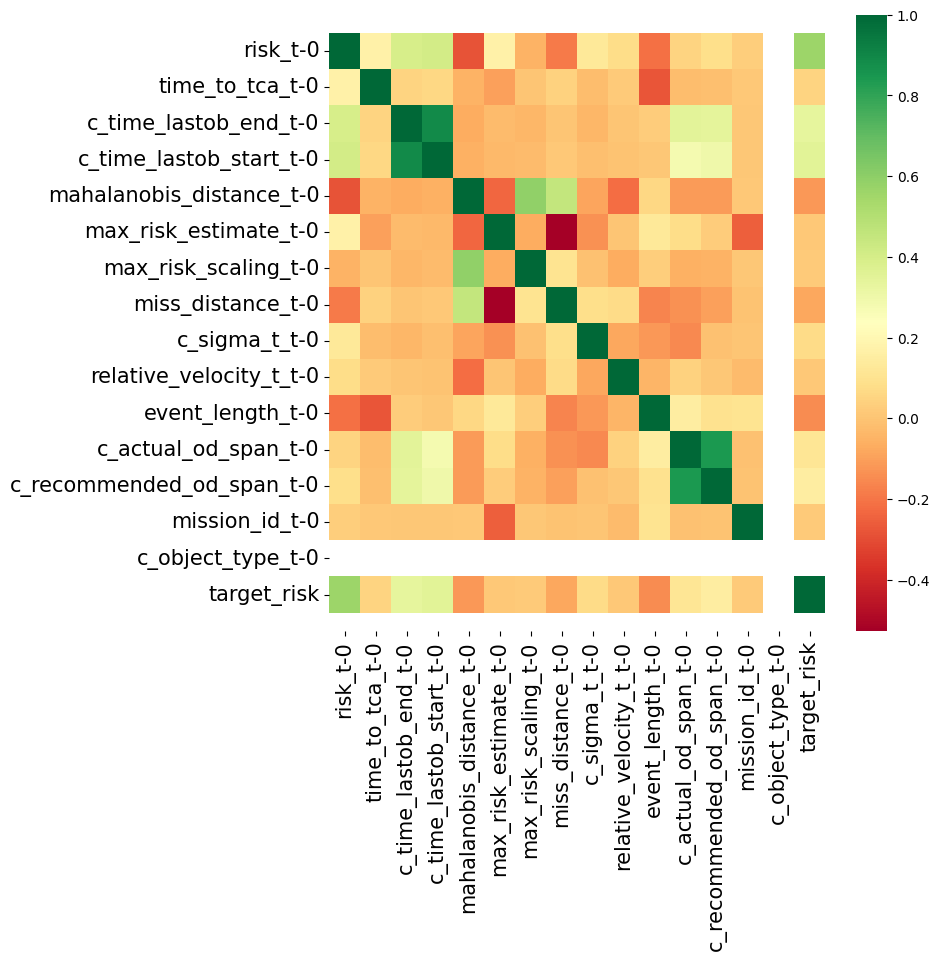

In [15]:
df_numeric = df.apply(pd.to_numeric, errors='coerce')
corr_matrix = df_numeric.corr()
plt.figure(figsize=(8,8))
hm = sns.heatmap(corr_matrix,cmap="RdYlGn", annot=False)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 15)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 15)        
plt.show()

In [13]:
df_corr = corr_matrix
df_corr = df_corr.loc[df_corr["target_risk"]>=0.5]